**Importing** **libraries**

In [41]:
from __future__ import print_function
#%matplotlib inline
import torch
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
from PIL import Image
import random
from pathlib import Path
import shutil

**Configue**

In [42]:

batch_size = 128
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

**Importing data**

In [43]:
image_path=Path('/content')
!wget -cq https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
shutil.unpack_archive("/content/flower_photos.tgz")
image_path=Path('/content/flower_photos')
print(image_path)
images_paths_list=list(image_path.glob('*/*.jpg'))
print(images_paths_list)
img=Image.open(random.choice(images_paths_list))


/content/flower_photos
[PosixPath('/content/flower_photos/tulips/17066864992_1cbc4fc908.jpg'), PosixPath('/content/flower_photos/tulips/2426849837_baefd9a518_n.jpg'), PosixPath('/content/flower_photos/tulips/3637371174_a8dfcc1b35.jpg'), PosixPath('/content/flower_photos/tulips/4562423077_00b16240dc_n.jpg'), PosixPath('/content/flower_photos/tulips/6994351792_343e18cbf6_n.jpg'), PosixPath('/content/flower_photos/tulips/3498663243_42b39b4185_m.jpg'), PosixPath('/content/flower_photos/tulips/7177682195_c29265748d_n.jpg'), PosixPath('/content/flower_photos/tulips/17165583356_38cb1f231d_n.jpg'), PosixPath('/content/flower_photos/tulips/17012955700_7141d29eee.jpg'), PosixPath('/content/flower_photos/tulips/8511683706_4173683d45_m.jpg'), PosixPath('/content/flower_photos/tulips/8702982836_75222725d7.jpg'), PosixPath('/content/flower_photos/tulips/17202535346_ab828e779b.jpg'), PosixPath('/content/flower_photos/tulips/13529687904_3d60abb479_n.jpg'), PosixPath('/content/flower_photos/tulips/1353

In [44]:
##Transforming data
from torchvision import datasets,transforms
data_transform=transforms.Compose([transforms.Resize(size=(image_size,image_size)),transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor()])

torch.Size([3, 64, 64])
439
500


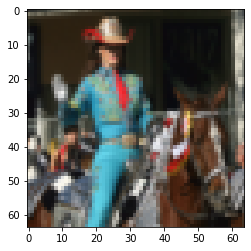

In [56]:
from matplotlib import pyplot as plt
transformed_image=data_transform(img)
print(transformed_image.shape)
transformed_image=transformed_image.permute(1,2,0)
plt.imshow(transformed_image)
print(img.height)
print(img.width)


In [46]:
data=datasets.ImageFolder(root=image_path,transform=data_transform,target_transform=None)
dataloader=torch.utils.data.DataLoader(dataset=data,batch_size=16,shuffle=True)

In [47]:



batch=next(iter(dataloader))

print(batch[0].shape)

torch.Size([16, 3, 64, 64])


## **sample of data
**

cuda:0


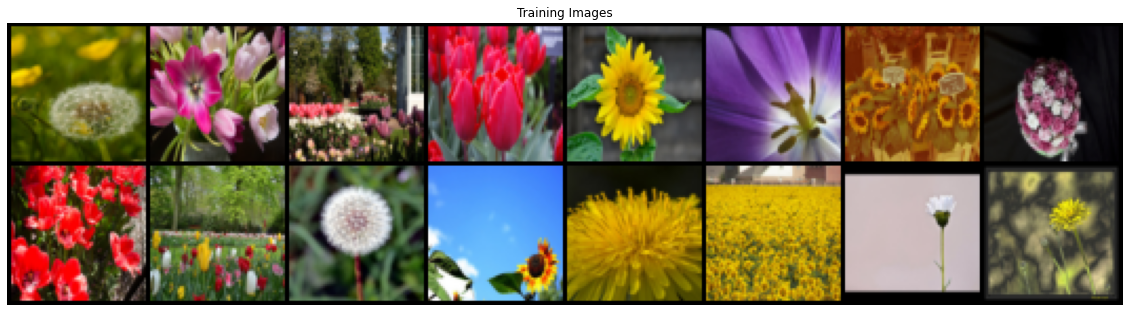

In [48]:

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")

grid=vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu()

plt.imshow(np.transpose(grid,(1,2,0)))

**Weight initialization**

In [49]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [50]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
       
            # input is Z, going into a convolution
        self.convT1=nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.batch1=nn.BatchNorm2d(ngf * 8)
        self.ReLU=nn.ReLU(True)
        self.convT2=nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.batch2=nn.BatchNorm2d(ngf*4)
        self.convT3=nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.batch3=nn.BatchNorm2d(ngf * 2)
        self.convT4=nn.ConvTranspose2d( ngf *2 , ngf, 4, 2, 1, bias=False)
        self.batch4=nn.BatchNorm2d(ngf)
        self.convT5=nn.ConvTranspose2d( ngf , ngf, 4, 2, 1, bias=False)
        self.batch5=nn.BatchNorm2d(ngf)
        self.convT6=nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
        self.tan=nn.Tanh()
       
        
    def forward(self, input):
        x=self.convT1(input)
        # print(np.shape(x))
        x=self.batch1(x)
        x=self.ReLU(x)
        x=self.convT2(x)
        # print(np.shape(x))
        x=self.batch2(x)
        x=self.ReLU(x)
        x=self.convT3(x)
        x=self.batch3(x)
        x=self.ReLU(x)
        x=self.convT4(x)
        x=self.batch4(x)
        x=self.ReLU(x)
        # print(np.shape(x))
        # x=self.convT5(x)
        x=self.batch5(x)
        x=self.convT6(x)
        # print(np.shape(x))
        x=self.tan(x)
        # print(np.shape(x))
        return x

**Create the generator**

In [51]:

netG = Generator().to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)
# noise = torch.randn(batch_size, nz, 1, 1, device=device)
# netG(noise)

# print(netG)


Generator(
  (convT1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU): ReLU(inplace=True)
  (convT2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT6):

In [52]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
           
        self.conv1=nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.leaky=nn.LeakyReLU(0.2, inplace=True)
        self.conv2=nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.batch1=nn.BatchNorm2d(ndf * 2)
      
     
        self.conv3=nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.batch2=nn.BatchNorm2d(ndf * 4)
        
      
        self.conv4=nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.batch3=nn.BatchNorm2d(ndf * 8)
        
        self.conv5=nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False)
        self.batch4=nn.BatchNorm2d(ndf * 8)
       
        self.conv6=nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False)
        self.conv7=nn.Conv2d(1, 1, 3, 1, 0, bias=False)
        self.sigmoid=nn.Sigmoid()
     

    def forward(self, input):
 
        x=self.conv1(input)
        x=self.leaky(x)
        x=self.conv2(x)
        x=self.batch1(x) 
        x=self.leaky(x)
        x=self.conv3(x)
        x=self.batch2(x)
        x=self.leaky(x)
        x=self.conv4(x)
        x=self.batch3(x)
        x=self.leaky(x)
        x=self.conv5(x)
        x=self.batch4(x)
        x=self.leaky(x)
        x=self.conv6(x)
        # x=self.conv7(x)
        x=self.sigmoid(x)
        # print(np.shape(x))


        return x

**Create the Discriminator**

In [53]:


netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# netD(real_batch[0].to(device))


# Print the model
#print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leaky): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (conv7): Conv2d(1, 1, kernel_siz


**Initialize BCELoss function**

In [54]:
criterion = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Train** **stage**

In [55]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        # print('data:',np.shape(data[0]))
        # print('data:',data[1])
        netD.zero_grad()
        # Format batch
        # print(real_label)
        real_cpu = data[0].to(device)
        # print(np.shape(real_cpu))
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # print(label)
        # Forward pass real batch through D
        # print('out_put',np.shape(netD(real_cpu)))
        #print('output', np.shape(netD(real_cpu)))
        output = netD(real_cpu).view(-1)
        # print('output',np.shape(output))
        # Calculate loss on all-real batch
        # print(np.shape(output))
        # print(np.shape(label))
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/230]	Loss_D: 1.4415	Loss_G: 3.9864	D(x): 0.4606	D(G(z)): 0.4667 / 0.0215
[0/5][50/230]	Loss_D: 0.0018	Loss_G: 15.7239	D(x): 0.9982	D(G(z)): 0.0000 / 0.0000
[0/5][100/230]	Loss_D: 0.0012	Loss_G: 18.9109	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[0/5][150/230]	Loss_D: 0.0119	Loss_G: 19.1104	D(x): 0.9889	D(G(z)): 0.0000 / 0.0000
[0/5][200/230]	Loss_D: 0.0002	Loss_G: 18.5252	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[1/5][0/230]	Loss_D: 0.6319	Loss_G: 13.8033	D(x): 0.7073	D(G(z)): 0.0000 / 0.0000
[1/5][50/230]	Loss_D: 1.6439	Loss_G: 5.1505	D(x): 0.9135	D(G(z)): 0.7845 / 0.0087
[1/5][100/230]	Loss_D: 0.1024	Loss_G: 3.3099	D(x): 0.9591	D(G(z)): 0.0583 / 0.0385
[1/5][150/230]	Loss_D: 0.1953	Loss_G: 3.1950	D(x): 0.9490	D(G(z)): 0.1297 / 0.0425
[1/5][200/230]	Loss_D: 0.1064	Loss_G: 3.5050	D(x): 0.9169	D(G(z)): 0.0128 / 0.0329
[2/5][0/230]	Loss_D: 0.5907	Loss_G: 1.7876	D(x): 0.6439	D(G(z)): 0.1047 / 0.1926
[2/5][50/230]	Loss_D: 0.3099	Loss_G: 2.7701	D(x): 0.9650	D(G(z))

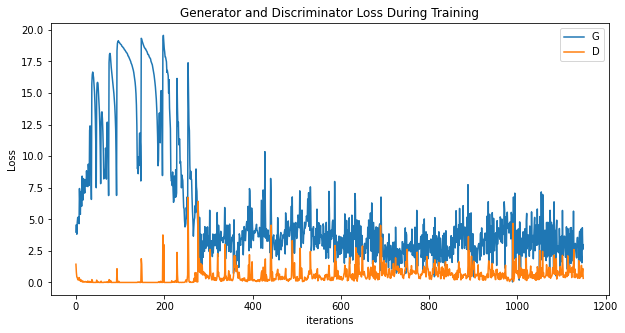

In [57]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

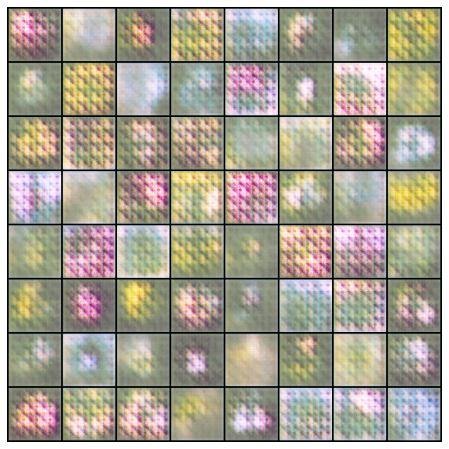

In [58]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())